In [12]:
!pip install -r "../requirements.txt"


In [13]:
import os

documents_dir = "documents/"
target_folders = ["Condotril", "Duobiotic", "Neurofil"]  # nomes dos produtos
documents = {folder: "" for folder in target_folders}  # Inicializa um dicionário para cada produto

for folder in target_folders:
    folder_path = os.path.join(documents_dir, folder)
    
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        for doc_name in os.listdir(folder_path):
            if doc_name.endswith(".txt"):
                print(f"txt encontrado ({doc_name})!")
                file_path = os.path.join(folder_path, doc_name)
                with open(file_path, "r", encoding="utf-8") as doc:
                    content = doc.read()
                    documents[folder] += content + "\n"

txt encontrado (Condotril_bula.txt)!
txt encontrado (Duobiotic_bula.txt)!
txt encontrado (Neurofil_bula.txt)!


In [14]:
documents

{'Condotril': '=D MYPharmã\n\nCONDOTRIL\n\nO QUE É CONDOTRIL?\n\nCONDOTRIL é um suplemento alimentar que contém Sulfato de Glucosamina, Sulfato de Condroitina,\nMSM e outros compostos como a Vitamina C e Manganês. A Vitamina C contribui para a normal for-\nmação de colagénio para o funcionamento normal dos ossos e das cartilagens. O Manganês con-\ntribui para a manutenção de ossos normais e a normal formação de tecidos conjuntivos.\n\nOs suplementos alimentares são géneros alimentícios que se destinam a complementar e/ou a\nsuplementar o regime alimentar normal não devendo ser utilizados como substitutos de um regime\nalimentar variado. Constituem fontes concentradas de determinadas substâncias nutrientes ou\noutras, com efeito nutricional ou fisiológico. É importante um regime alimentar equilibrado e um\nmodo de vida saudável.\n\nIngredientes: Agente de volume: Maltodextrina; Sulfato de glucosamina (marinho); Sulfato\nde condroitina; Agente de volume: Fosfato dicálcico; Cartilagem de 

# Question Generator

In [15]:
from langchain_ollama.llms import OllamaLLM

model = OllamaLLM(model="llama3.1:8b")

# original questions

questions = ["Quais sao os ingredientes do Condotril?",
"Quais sao os ingredientes do Duobiotic?",
"Quais sao os ingredientes do Neurofil?",
"Quais sao os efeitos do Condotril?",
"Quais sao os efeitos do Duobiotic?",
"Quais sao os efeitos do Neurofil?",
"Qual e o processo de toma do Condotril?",
"Qual e o processo de toma do Duobiotic?",
"Qual e o processo de toma do Neurofil?",
"Quais sao as condicoes de armazenamento do Condotril?",
"Quais sao as condicoes de armazenamento do Duobiotic?",
"Quais sao as condicoes de armazenamento do Neurofil?",
"Em que casos nao se pode tomar Condotril?",
"Em que casos nao se pode tomar Duobiotic?",
"Em que casos nao se pode tomar Neurofil?",
"Quantas doses tem a embalagem do Condotril?",
"Quantas doses tem a embalagem do Duobiotic?",
"Quantas doses tem a embalagem do Neurofil?"]

### Variants

In [16]:
def generate_variants(model, questions, n=4):
    variants = {}
    for question in questions:
        system_prompt =  """Your role is to rephrase this question in different ways, keeping the meaning: {question}.
        Never give a question in english, only in portuguese.""".format(question=question)

        response = model.generate(prompts=[system_prompt], num_return_sequences=n)
        variants[question] = [variant for variant in response.generations]
    return variants

In [ ]:
!ollama pull llama3.1


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest 
pulling 8eeb52dfb3bb... 100% ▕████████████████▏ 4.7 GB                         
pulling 948af2743fc7... 100% ▕████████████████▏ 1.5 KB                         
pulling 0ba8f0e314b4... 100% ▕████████████████▏  12 KB                         
pulling 56bb8bd477a5... 100% ▕████████████████▏   96 B                         
pulling 1a4c3c319823... 100% ▕████████████████▏  485 B                         
verifying sha256 digest 
writing manifest 
success 
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest 
Error: pull model manifest: file does not exist


In [18]:
question_variants = generate_variants(model, questions, n=4)

In [19]:
for original, variants in question_variants.items():
    print(f"Original: {original}")
    for i, variant in enumerate(variants, 1):
        print(f"Variant {i}: {variant}")
    print()

Original: Quais sao os ingredientes do Condotril?
Variant 1: [GenerationChunk(text='Aqui estão algumas variantes da pergunta:\n\n* Qual é a composição química do Condotril?\n* O que contém o Condotril em termos de substâncias ativas e inativas?\n* Que ingredientes fazem parte da fórmula do Condotril?\n* Quais são os componentes do Condotril?\n* Em que consiste a formulação do Condotril?', generation_info={'model': 'llama3.1:8b', 'created_at': '2024-11-27T13:08:04.861440684Z', 'done': True, 'done_reason': 'stop', 'total_duration': 106764008701, 'load_duration': 18174388482, 'prompt_eval_count': 52, 'prompt_eval_duration': 18814705000, 'eval_count': 89, 'eval_duration': 69726612000, 'response': '', 'context': [128006, 882, 128007, 271, 7927, 3560, 374, 311, 312, 28810, 420, 3488, 304, 2204, 5627, 11, 10494, 279, 7438, 25, 3489, 2852, 104372, 2709, 25795, 288, 656, 1221, 16510, 31660, 30, 627, 286, 15037, 3041, 264, 3488, 304, 30063, 11, 1193, 304, 2700, 773, 36554, 13, 128009, 128006, 78

### Display and dictionary + Normalize variants

In [20]:
import re
import unicodedata

def remove_acentos(text):
    nfkd_form = unicodedata.normalize('NFKD', text)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_pontuation(text):
        return re.sub(r"[^\w\s]", "", text) # remove todos os caracteres exceto letras e numeros

var = {}
var_normalized = {}

for original, variants in question_variants.items():
    QV = []
    #return re.sub(r"[^\w\s\!\?\.\']", "", text)
    for variant in variants:
        responses = re.split(r'[\n\*|\n,]', variant[0].text)
        responses = [resp.strip() 
                     for resp in responses[1:] if resp.strip()]
        QV.extend(responses)
    var[original] = QV

for original, variants in var.items():
    QV = []
  
    original = remove_acentos(remove_pontuation(original))
    
    for variant in variants:
        variant = remove_pontuation(variant) 
        variant = remove_acentos(variant)
        
        QV.append(variant)
    
    var_normalized[original] = QV

    print(f"Original: {original}")
    print("Variantes:")
    for variant in var_normalized[original]:
        print("- ", variant)
    print()

Original: Quais sao os ingredientes do Condotril
Variantes:
-  Qual e a composicao quimica do Condotril
-  O que contem o Condotril em termos de substancias ativas e inativas
-  Que ingredientes fazem parte da formula do Condotril
-  Quais sao os componentes do Condotril
-  Em que consiste a formulacao do Condotril

Original: Quais sao os ingredientes do Duobiotic
Variantes:
-  Qual e a composicao do Duobiotic
-  Que ingredientes contem o Duobiotic
-  O que esta presente no Duobiotic
-  Quais sao os componentes ativos do Duobiotic
-  Em que consiste o Duobiotic quimicamente

Original: Quais sao os ingredientes do Neurofil
Variantes:
-  O que e composto o Neurofill
-  Qual e a composicao do Neurofill
-  Em que ingredientes e composto o Neurofill
-  Quais substancias fazem parte do Neurofill
-  O que contem o Neurofill

Original: Quais sao os efeitos do Condotril
Variantes:
-  O que acontece quando se utiliza o Condotril
-  Quais sao as consequencias do uso do Condotril
-  Como o Condotr

## Variants dataset

In [21]:
import pandas as pd

variants_df = pd.DataFrame(list(var_normalized.items()), columns=["original", "variants"])
max_variants = max(variants_df["variants"].apply(len))
variants_expanded = pd.DataFrame(variants_df["variants"].tolist(), columns=[f"variant_{i+1}" for i in range(max_variants)])
variants_df = pd.concat([variants_df["original"], variants_expanded], axis=1)

In [22]:
variants_df

,original,variant_1,variant_2,variant_3,variant_4,variant_5,variant_6,variant_7,variant_8,variant_9,variant_10,variant_11,variant_12
0,Quais sao os ingredientes do Condotril,Qual e a composicao quimica do Condotril,O que contem o Condotril em termos de substanc...,Que ingredientes fazem parte da formula do Con...,Quais sao os componentes do Condotril,Em que consiste a formulacao do Condotril,None,None,None,None,None,None,None
1,Quais sao os ingredientes do Duobiotic,Qual e a composicao do Duobiotic,Que ingredientes contem o Duobiotic,O que esta presente no Duobiotic,Quais sao os componentes ativos do Duobiotic,Em que consiste o Duobiotic quimicamente,None,None,None,None,None,None,None
2,Quais sao os ingredientes do Neurofil,O que e composto o Neurofill,Qual e a composicao do Neurofill,Em que ingredientes e composto o Neurofill,Quais substancias fazem parte do Neurofill,O que contem o Neurofill,None,None,None,None,None,None,None
3,Quais sao os efeitos do Condotril,O que acontece quando se utiliza o Condotril,Quais sao as consequencias do uso do Condotril,Como o Condotril afeta os individuos ou a soci...,Quais sao os efeitos colaterais do Condotril,Qual e o resultado pratico da utilizacao do Co...,O que se pode esperar quando se utiliza o Cond...,Essas reformulacoes mantem o mesmo significado...,mas apresentam diferentes enfoques e perspectivas,None,None,None,None
4,Quais sao os efeitos do Duobiotic,O que acontece quando alguem toma Duobiotic,Os resultados colaterais do Duobiotic sao quais,Quais sao as consequencias de tomar Duobiotic,Qual e a reacao do corpo ao Duobiotic,Efeitos adversos ou secundarios do Duobiotic q...,O que acontece no organismo quando se toma Duo...,Consequencias do uso de Duobiotic quais sao elas,None,None,None,None,None
5,Quais sao os efeitos do Neurofil,1 Qual e o resultado do uso de Neurofil,2 O que acontece quando se toma ou usa Neurofil,3 Quais sao as consequencias do consumo de Neu...,4 Como afeta a saude o uso de Neurofil,5 O que ocorre no corpo com o consumo de Neurofil,6 Quais sao os efeitos colaterais do uso de Ne...,7 Qual e o impacto do Neurofil na saude humana,8 O que acontece quando se administra ou se to...,Essas perguntas mantem a essencia da pergunta ...,mas expressam a ideia de forma ligeiramente di...,None,None
6,Qual e o processo de toma do Condotril,Quais sao as etapas envolvidas na construcao d...,Como foi projetado e construido o Condominio C...,O que e o processo de criacao de um condominio...,Quais sao os passos para a realizacao de um pr...,Qual foi a sequencia de eventos que levou a co...,None,None,None,None,None,None,None
7,Qual e o processo de toma do Duobiotic,Como e feita a administracao do Duobiotic,Qual e o procedimento de tomada do Duobiotic,O que se deve fazer para tomar Duobiotic,Como tomar corretamente Duobiotic,Quais sao os passos para consumir Duobiotic,None,None,None,None,None,None,None
8,Qual e o processo de toma do Neurofil,1 Como se adquire o Neurofil,2 Quais sao os passos para obter um Neurofil,3 O que e necessario para tomar um Neurofil,4 Qual e a forma de contratar ou fazer uso de ...,5 Como funciona a tomada ou aquisicao de um Ne...,6 Existem requisitos para se tornar titular de...,7 Quais sao os procedimentos necessarios para ...,None,None,None,None,None
9,Quais sao as condicoes de armazenamento do Con...,Em que condicoes o Condotril deve ser armazenado,Como devem ser armazenados os condotrios,Quais sao as especificacoes de armazenamento d...,Onde e como o Condotril pode ser armazenado,Quais condicoes sao necessarias para armazenar...,None,None,None,None,None,None,None


In [23]:
variants_df.to_csv('variants.csv')

### Handle speling

In [35]:
from fuzzywuzzy import fuzz
from autocorrect import Speller
from spellchecker import SpellChecker
import re
import csv

def load_variants_from_csv(file_path):
    quest_variants = {}
    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            original = row['original']  # A coluna principal com a pergunta original
            # Filtrar todas as variantes não vazias
            variants = [row[key] for key in row if key.startswith('variant_') and row[key].strip()]
            quest_variants[original] = variants  # Mapear original -> lista de variantes
    return quest_variants

# spell = Speller(lang='pt')
spell = SpellChecker(language='pt')

def normalize_text(text):
        return re.sub(r"[^\w\s']", "", text)


def choose_best_question_variant(user_question, quest_variants):
    best_score = 0
    best_match = None

    # print("original:", user_question)

    # user_question = spell(user_question) # CATARINA
    # user_question = spell.correction(user_question) # MARTA
    # print("spell.correction: ", user_question) # NAO FUNCIONA ############################################################

    user_question = normalize_text(user_question)
    # print("normalize_text: ", user_question)

    user_question = remove_acentos(remove_pontuation(user_question))
    # print("remove_acentos: ", user_question, "\n")
    
    user_question = user_question.lower()

    # Comparação com perguntas originais e variantes
    for original, variants in quest_variants.items():
        # Verifica a similaridade com a pergunta original
        score_with_original = fuzz.ratio(user_question, original.lower())
        if score_with_original > best_score:
            best_score = score_with_original
            best_match = original
            # Se a original for altamente semelhante, priorize-a
            if best_score >= 98:
                break

        # Verifica a similaridade com cada variante
        for variant in variants:
            score_with_variant = fuzz.ratio(user_question, variant.lower())
            if score_with_variant > best_score:
                best_score = score_with_variant
                best_match = original

    return best_match


In [36]:
teste_com_erros = "quantós comprmídos d~evo tomâr de duobitiic?"
file_path = 'variants.csv'
variants = load_variants_from_csv(file_path)
result = choose_best_question_variant(teste_com_erros, variants)
print(f"User question: {teste_com_erros}\nMelhor variante:", result)

User question: quantós comprmídos d~evo tomâr de duobitiic?
Melhor variante: Qual e o processo de toma do Duobiotic


# Create Chunks

In [37]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=1200, # o chunk_size tem que ser grande para termos o maximo de informaçao sobre um produto num vetor apenas
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)

docs = []
for name, content in documents.items():
    # Adiciona o nome do medicamento no início do conteúdo antes de dividir
    full_content = f"Medicamento: {name}\n\n{content}"
    chunks = text_splitter.create_documents([full_content])
    
    # Adiciona o nome do medicamento diretamente ao conteúdo de cada chunk
    for chunk in chunks:
        chunk.metadata = {"medicamento": name}
        chunk.page_content = f"{name}\n\n{chunk.page_content}"
    
    docs.extend(chunks)

for _, (product, content) in enumerate(documents.items()):
    num_characters = len(content)
    print(f"Número de caracteres no documento '{product}': {num_characters}")

print("Número de documents: ", len(docs))

Número de caracteres no documento 'Condotril': 3161
Número de caracteres no documento 'Duobiotic': 3207
Número de caracteres no documento 'Neurofil': 2871
Número de documents:  10


In [38]:
docs

[Document(metadata={'medicamento': 'Condotril'}, page_content='Condotril\n\nMedicamento: Condotril\n\n=D MYPharmã\n\nCONDOTRIL\n\nO QUE É CONDOTRIL?\n\nCONDOTRIL é um suplemento alimentar que contém Sulfato de Glucosamina, Sulfato de Condroitina,\nMSM e outros compostos como a Vitamina C e Manganês. A Vitamina C contribui para a normal for-\nmação de colagénio para o funcionamento normal dos ossos e das cartilagens. O Manganês con-\ntribui para a manutenção de ossos normais e a normal formação de tecidos conjuntivos.\n\nOs suplementos alimentares são géneros alimentícios que se destinam a complementar e/ou a\nsuplementar o regime alimentar normal não devendo ser utilizados como substitutos de um regime\nalimentar variado. Constituem fontes concentradas de determinadas substâncias nutrientes ou\noutras, com efeito nutricional ou fisiológico. É importante um regime alimentar equilibrado e um\nmodo de vida saudável.'),
 Document(metadata={'medicamento': 'Condotril'}, page_content='Condotr

# Create VectorStore/Retriever

In [40]:
# ollama needs to be installed
# https://ollama.com/
# https://github.com/ollama/ollama/tree/main/docs
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS

embedding_model = OllamaEmbeddings(
    # model="nomic-embed-text",
    model="llama3.1:8b",
)

vectorstore = FAISS.from_documents(docs, embedding=embedding_model)
vectorstore.save_local(folder_path = 'vectorstore') # save the vectorstore locally

In [41]:
retriever = FAISS.load_local(
    folder_path='vectorstore',
    embeddings=embedding_model,
    allow_dangerous_deserialization=True
    ).as_retriever(search_kwargs={"k" : 5})

# Load Document

In [ ]:
question = "Quais são os ingredientes do Condotril"
result = choose_best_question_variant(question, variants)
retriever.invoke(result)

[Document(metadata={'medicamento': 'Condotril'}, page_content='Condotril\n\nConsumir de preferência antes do fim de...: Ver embalagem. -\nLote: Ver embalagem.\n\nRepresentado e distribuído por:\nMYPHARMA S.A.\n\nTv. António Ferreira Rito, 43\n4705-112 Braga - PORTUGAL\n\ngeralomypharma,.pt Good Mm..nSI..MZ &\n\nwww.mypharma.pt'),
 Document(metadata={'medicamento': 'Neurofil'}, page_content='Neurofil\n\nMedicamento: Neurofil\n\nNEUROFIL\n\n60 CÁPSULAS MOLES\n\nO QUE É NEUROFIL?\n\nNeurofil é um suplemento alimentar que contém óleo de peixe concentrado em ácidos gordos Ómega-a. com quantidades\nrelevantes de DHA / EPA num rácio de 3:1. Inclui ainda magnésio, vitamina B12 e ácido fólico. Os suplementos alimentares são\ngéneros alimentícios que se destinam a complementar e/ou a suplementar o regime alimentar normal não devendo ser\nutilizados como substitutos de um regime alimentar variado. Constituem fontes concentradas de determinadas substâncias\nnutrientes ou outras, com efeito nutrici

In [43]:
import re
from langchain.tools import BaseTool

class ArticleInformation(BaseTool):
    name: str = "ArticleInformation"
    description: str = "This tool is used to answer questions about MyPharma food suplements. The input is the original user question"
    
    # def _run(self, question):
    #     retrieved_documents = retriever.invoke(question)
    #     return [document.page_content for document in retrieved_documents]
    
    def _run(self, question):
        retrieved_documents = retriever.invoke(question)  # Obtém documentos
        medicamentos = self._extract_medicamento(question)  # Extrai os nomes dos medicamentos (lista)
        
        # Filtra os documentos com base na metadata
        filtered_documents = [
            document for document in retrieved_documents
            if document.metadata.get('medicamento', '').lower() in {med.lower() for med in medicamentos}
        ]
        
        # Retorna os conteúdos dos documentos filtrados
        return [document.page_content for document in filtered_documents]

    
    def _extract_medicamento(self, question: str) -> list[str]:
        """Tenta identificar os medicamentos mencionados na pergunta."""
        # Lista fixa de medicamentos disponíveis
        medicamentos_disponiveis = {"Condotril", "Neurofil", "Duobiotic"}

        # Procura por todos os medicamentos mencionados na pergunta
        matches = re.findall(r'(Condotril|Neurofil|Duobiotic)', question, flags=re.IGNORECASE)
        
        # Filtra para capturar somente os medicamentos válidos, eliminando duplicatas
        medicamentos_identificados = {match.capitalize() for match in matches if match.capitalize() in medicamentos_disponiveis}
        
        if medicamentos_identificados:
            return list(medicamentos_identificados)
        else:
            raise ValueError("Não foi possível identificar nenhum medicamento na pergunta.")


# Develop Chatbot workflow (langgraph)

Tools

In [44]:
tools = [ArticleInformation()]
tools_by_name = {tool.name: tool for tool in tools}

AgentState

In [46]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

System Prompt

In [47]:
from langchain_core.messages import SystemMessage

system_prompt =  SystemMessage("""Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. 
  
Your final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.
Do not oversimplify or summarize the answer.

If you are unsure about what tool to use or how to correct an error, you should ask the user for help.""")

Nodes

In [48]:
from typing import Union, Literal
from langchain_ollama import ChatOllama # you can use other chat models from langchain. they need, however, to have function call capabilities (https://python.langchain.com/docs/integrations/chat/)
from langchain_core.messages import ToolMessage, HumanMessage
import json


# ollama needs to be installed
# https://ollama.com/
# https://github.com/ollama/ollama/tree/main/docs
def call_llm(state: AgentState) -> dict[str, Union[list, bool]]:
        """
        Calls the LLM model.
        
        Parameters
        ----------
        state : AgentState
            The state of the agent.
            
        Returns
        -------
        dict[str, Union[list, bool]]
            The updated state after calling the LLM model.
        """
        llm = ChatOllama( model="llama3.1:8b", temperature=0) #instantiates the LLM model
        llm = llm.bind_tools([ArticleInformation()]) #binds the tools to the LLM model
        llm_response = llm.invoke(state['messages']) #calls the LLM model
        
        return {'messages': [llm_response]} #returns the updated state
    
def tool_node(state: AgentState) -> dict[str, Union[list, bool]]:
    '''
    Runs the tool requested in the last AI message (with the tool call).
    
    Parameters
    ----------
    state : AgentState
        The state of the agent.
        
    Returns
    -------
    dict[str, Union[list, bool]]
        The updated state after running the tool.
    '''
    if messages := state.get('messages', []):
        message = messages[-1]
    else:
        raise ValueError('No messages found in input state.')
    
    outputs = []
    
    # tool_call example
    # [{'name': 'ThesisInformation',
    # 'args': {'query': 'What is the...'},
    # 'id': 'call_UwQzgi1QD9uWfBP1r6CWO5ep',
    # 'type': 'tool_call'}]
    
    for tool_call in message.tool_calls:
        tool_result = tools_by_name[tool_call['name']].invoke(
            tool_call['args']
        )
        
        outputs.append(
            ToolMessage(
                content = json.dumps(tool_result),
                name = tool_call['name'],
                tool_call_id = tool_call['id']
            )
        )

    return {'messages': outputs}


def route_tools(state: AgentState) -> Literal['tools', '__end__']:
        '''
        To be used in the conditional_edge method when compiling the graph.
        Routes to the tool node if the last message contains a tool call.
        Otherwise, routes to the end.
        
        Parameters
        ----------
        state : ReactState
            The state of the agent.
            
        Returns
        -------
        Literal['tools', '__end__']
            The next node to route to.
        '''        
        if isinstance(state, list):
            ai_message = state[-1]
        elif messages := state.get('messages', []):
            ai_message = messages[-1]
        else:
            raise ValueError(f'No messages found in input state to tool edge: {state}')
        
        if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
            return 'tools'
        return '__end__'

Compile Graph

In [49]:
from langgraph.graph import StateGraph, START

graph = StateGraph(AgentState)
graph.add_node('llm', call_llm)
graph.add_node('tools', tool_node)
graph.add_edge('tools', 'llm')
graph.add_edge(START, 'llm')
graph.add_conditional_edges('llm', route_tools, {'tools': 'tools', '__end__': '__end__'})

#compile graph
graph = graph.compile()

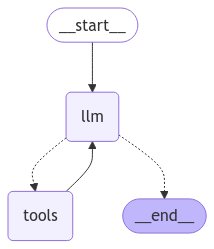

In [50]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


# Answers

In [51]:
# Qual é a composição do suplemento alimentar X?
# Quais são os efeitos do suplemento alimentar X? / O que faz o suplemento alimentar X?
# O que acontece se consumir X e tomar o suplemento alimentar Y?
# Como é o processo de toma do suplemento alimentar X?

# Ingredientes
question1 = "Quais são os ingredientes do Condotril?"
question2 = "Quais são os ingredientes do Duobiotic?"
question3 = "Quais são os ingredientes do Neurofil?"
question1 = choose_best_question_variant(question1, variants)
question2 = choose_best_question_variant(question2, variants)
question3 = choose_best_question_variant(question3, variants)

# Benefícios
question4 = "Quais são os benefícios do Condotril?"
question5 = "Quais são os benefícios do Duobiotic?"
question6 = "Quais são os benefícios do Neurofil?"
question4 = choose_best_question_variant(question4, variants)
question5 = choose_best_question_variant(question5, variants)
question6 = choose_best_question_variant(question6, variants)

# Efeitos
question7 = "Quais são os efeitos do Condotril?"
question8 = "Quais são os efeitos do Duobiotic?"
question9 = "Quais são os efeitos do Nueurofil?"
question7 = choose_best_question_variant(question7, variants)
question8 = choose_best_question_variant(question8, variants)
question9 = choose_best_question_variant(question9, variants)

# Processo de toma
question10 = "Qual é o processo de toma do Condotril?"
question11 = "Qual é o processo de toma do Duobiotic?"
question12 = "Qual é o processo de toma do Neurofil?"
question10 = choose_best_question_variant(question10, variants)
question11 = choose_best_question_variant(question11, variants)
question12 = choose_best_question_variant(question12, variants)

# Condições de armazenamento
question13 = "Quais são as condições de armazenamento do Condotril?"
question14 = "Quais são as condições de armazenamento do Duobiotic?"
question15 = "Quais são as condições de armazenamento do Neurofil?"
question13 = choose_best_question_variant(question13, variants)
question14 = choose_best_question_variant(question14, variants)
question15 = choose_best_question_variant(question15, variants)

# Precaussões
question16 = "Em que casos não se pode tomar Condotril?"
question17 = "Em que casos não se pode tomar Duobiotic?"
question18 = "Em que casos não se pode tomar Neurofil?"
question16 = choose_best_question_variant(question16, variants)
question17 = choose_best_question_variant(question17, variants)
question18 = choose_best_question_variant(question18, variants)

In [52]:
import csv

def save_question_answer(question, answer, csv_file='questions_answers.csv'):
    file_exists = False
    try:
        with open(csv_file, mode='r', encoding='utf-8') as file:
            file_exists = True
    except FileNotFoundError:
        pass

    # Escreve no CSV
    with open(csv_file, mode='a', encoding='utf-8', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['question', 'answer'])

        # Escreve o header apenas se o arquivo for criado agora
        if not file_exists:
            writer.writeheader()

        # Adiciona os dados
        writer.writerow({'question': question, 'answer': answer})

In [53]:
response1 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question1)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}),
              HumanMessage(content='Quais sao os ingredientes do Condotril', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n  \nYour final answer should be as 

In [54]:
print("Pergunta: ", question1)
print("Resposta: ", response1['messages'][-1].content)
save_question_answer(question1, response1['messages'][-1].content)

Pergunta:  Quais sao os ingredientes do Condotril
Resposta:  Os ingredientes do Condotril são:

* Agente de volume: Maltodextrina
* Sulfato de glucosamina (marinho)
* Sulfato de condroitina
* Agente de volume: Fosfato dicálico
* Cartilagem de tubarão
* Aroma de laranja
* Metilsulfonilmetano (MSM)
* Extrato seco de Bambusa vulgaris (Bambu), exsudado do caule, doseado a 75% de Sílica
* Extrato seco de Harpagophytum procumbens (Harpago), raiz, doseado a 2% de Harpágidos
* Acidificante: Ácido cítrico
* Colageno hidrolisado tipo I
* Vitamina C (Ácido t-ascorbico)
* Antiaglomerante: Dióxido de silício
* Gluconmato de manganês (Manganês)
* Hialuronato de sódio (Ácido hialurônico)
* Edulcorante: Sucralose

Além disso, o Condotril também contém os seguintes ingredientes em quantidades diárias:

* Sulfato de Glucosamina: 750 mg
* Sulfato de Condroitina: 300 mg
* Cartilagem de tubarão: 150 mg
* Metilsulfonilmetano (MSM): 120 mg
* Sílica: 90 mg
* Extrato seco de Harpagophytum procumbens (Harpago):

In [55]:
bonus_question = "Qual é a diferença entre Duobiotic e Neurofil?"
# bonus_question = choose_best_question_variant(bonus_question, variants)
print(bonus_question)

Qual é a diferença entre Duobiotic e Neurofil?


In [56]:
bonus_response = graph.invoke({'messages': [system_prompt, HumanMessage(content=bonus_question)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='918a6050-aca3-484b-8739-6ebda7d04aee'),
              HumanMessage(content='Qual é a diferença entre Duobiotic e Neurofil?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the g

In [57]:
print("Pergunta:", bonus_question)
print("Resposta:\n", bonus_response['messages'][-1].content)
save_question_answer(bonus_question, bonus_response['messages'][-1].content)

Pergunta: Qual é a diferença entre Duobiotic e Neurofil?
Resposta:
 O Duobiotic é um suplemento alimentar que contém lactobacilos e bifidobactérias, enriquecido com ácidos não digeríveis e vitaminas. Já o Neurofil parece ser uma substância relacionada ao sistema nervoso, mas não há informações suficientes para compará-los diretamente.

No entanto, é importante notar que o Duobiotic é um suplemento alimentar destinado a complementar e/ou a suplementar o regime alimentar normal, enquanto o Neurofil parece ser uma substância relacionada ao sistema nervoso. Portanto, eles têm objetivos e funções diferentes.

Em resumo, a diferença entre Duobiotic e Neurofil é que o primeiro é um suplemento alimentar destinado a promover a saúde intestinal, enquanto o segundo parece ser uma substância relacionada ao sistema nervoso.


### Comparar a respostas obtidas à resposta correta (fine-tunning?)

In [58]:
import pandas as pd

def load_dataframe(csv_file):
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')
        return df
    except FileNotFoundError:
        print(f"Erro: O arquivo '{csv_file}' não foi encontrado.")
        return pd.DataFrame(columns=['question', 'answer'])

In [59]:
df_generated = load_dataframe('questions_answers.csv')
df_generated

,question,answer
0,Quais sao os ingredientes do Condotril,Os ingredientes do Condotril são:\n\n- Agente ...
1,Qual é a diferença entre Duobiotic e Neurofil?,O Duobiotic é um suplemento alimentar que cont...
2,Quais sao os ingredientes do Condotril,Os ingredientes do Condotril são:\n\n* Agente ...
3,Qual é a diferença entre Duobiotic e Neurofil?,O Duobiotic é um suplemento alimentar que cont...


In [60]:
df_correct = load_dataframe('answers.csv')
df_correct

,Questions,Answers
0,Quais sao os ingredientes do Condotril?,Os ingredientes do Condotril incluem: agentes ...
1,Quais sao os ingredientes do Duobiotic?,Os ingredientes do Duobiotic incluem: Fruto-ol...
2,Quais sao os ingredientes do Neurofil?,Os ingredientes do Neurofil incluem:\nÓleo de ...
3,Quais sao os efeitos do Condotril?,Os efeitos do Condotril incluem melhorias na s...
4,Quais sao os efeitos do Duobiotic?,Os efeitos do Duobiotic incluem melhorias na s...
5,Quais sao os efeitos do Neurofil?,Os efeitos do Neurofil incluem a melhoria da f...
6,Qual e o processo de toma do Condotril?,O Duobiotic deve ser tomado 1 saqueta dia. Dis...
7,Qual e o processo de toma do Duobiotic?,O Duobiotic deve ser tomado 1 saqueta dia. Di...
8,Qual e o processo de toma do Neurofil?,O Neurofil deve ser tomado 1 a 2 cápsulas por ...
9,Quais sao as condicoes de armazenamento do Con...,Conservar em local seco na embalagem original ...


In [61]:
def compare_questions(df_generated, df_correct):
    for idx1, question1 in enumerate(df_generated['question']):

        best_match = None
        best_score = 0

        print(f"Pergunta Gerada ({idx1}): {question1}")
        for idx2, question2 in enumerate(df_correct['Questions']):
            score = fuzz.ratio(question1.lower(), question2.lower())

            if score > best_score:
                best_score = score
                best_match = question2
                

        print(f"Melhor Pergunta Similar: {best_match} (score={best_score})")
        print("-" * 50)

In [62]:
compare_questions(df_generated, df_correct)

Pergunta Gerada (0): Quais sao os ingredientes do Condotril
Melhor Pergunta Similar: Quais sao os ingredientes do Condotril? (score=99)
--------------------------------------------------
Pergunta Gerada (1): Qual é a diferença entre Duobiotic e Neurofil?
Melhor Pergunta Similar: Quais sao os ingredientes do Neurofil? (score=60)
--------------------------------------------------
Pergunta Gerada (2): Quais sao os ingredientes do Condotril
Melhor Pergunta Similar: Quais sao os ingredientes do Condotril? (score=99)
--------------------------------------------------
Pergunta Gerada (3): Qual é a diferença entre Duobiotic e Neurofil?
Melhor Pergunta Similar: Quais sao os ingredientes do Neurofil? (score=60)
--------------------------------------------------


In [63]:
# falta adaptar a função 'compare_questions' para que calcule a acuracy entre a resposta gerada (do dataframe 'df_generated')
# e a resposta correta (do dataframe 'df_correct')
# VER MELHOR O CODIGO ABAIXO (foi o chat que fez)

In [64]:
def compare_questions(df_generated, df_correct):
    for idx1, question1 in enumerate(df_generated['question']):
        best_match = None
        best_score = 0
        best_answer = None

        print(f"Pergunta Gerada ({idx1}): {question1}")
        for idx2, question2 in enumerate(df_correct['Questions']):
            score = fuzz.ratio(question1.lower(), question2.lower())

            if score > best_score:
                best_score = score
                best_match = question2
                best_answer = df_correct.loc[idx2, 'Answers']  # Obter resposta correspondente

        generated_answer = df_generated.loc[idx1, 'answer']  # Resposta gerada

        print(f"Melhor Pergunta Similar: {best_match} (score={best_score})")
        print(f"Resposta Correspondente à Melhor Pergunta: {best_answer}")
        print(f"Resposta Gerada: {generated_answer}")
        print(f"Similaridade entre Respostas: {fuzz.ratio(generated_answer.lower(), best_answer.lower())}")
        print("-" * 50)

In [65]:
compare_questions(df_generated, df_correct)

Pergunta Gerada (0): Quais sao os ingredientes do Condotril
Melhor Pergunta Similar: Quais sao os ingredientes do Condotril? (score=99)
Resposta Correspondente à Melhor Pergunta: Os ingredientes do Condotril incluem: agentes de volume como Maltodextrina e Fosfato dicálcico; 
            compostos principais ativos: Sulfato de glucosamina (marinho), 
            Sulfato de condroitina,
            Cartilagem de tubarão,
            Metilsulfonilmetano (MSM),
            Extrato seco de Bambusa vulgaris (bambu), 
            exsudado do caule (doseado a 75% de sílica), 
            Extrato seco de Harpagophytum procumbens (harpago), 
            raiz (doseado a 2% de harpagósidos), 
            Colagénio hidrolisado tipo II, 
            Ácido hialurónico (hialuronato de sódio) 
            e outros ingredientes como: Aroma de laranja, 
            Ácido cítrico (acidificante),
            Dióxido de silício (antiaglomerante), 
            Gluconato de manganês (manganês) e Sucralose (ed

In [2]:

def get_chatbot_response(question):
    # Escolhe a melhor variante da pergunta
    result = choose_best_question_variant(question, variants)
    
    # Invoca o retriever com a pergunta variante
    response = retriever.invoke(result)
    
    return response
